In [14]:
import os
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from pathlib import Path

plt.ion()

# Configuration and Experiment Parameters

In [2]:
PATH = Path('/media/bread/wdblue/deep_image_matting/Combined_Dataset/Training_set')
FG = Path('fg')
BG = Path('bg')
MASKS = Path('mask')

# Build Dataloader with Transforms

In [3]:
df = pd.read_csv(PATH/'train.csv')
df.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [4]:
def show_masked_image(image, mask):
    plt.imshow(image)
    plt.imshow(mask, alpha=0.3)
    plt.pause(0.001)

In [5]:
class SaltDataset(Dataset):    
    def __init__(self, csv_file, root_dir, transform=None):
        self.salt_frame = pd.read_csv(root_dir/csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.salt_frame)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir,
                                'train128',
                                self.salt_frame.iloc[idx, 0]+'.png')
        mask_path = os.path.join(self.root_dir,
                                 'masks128',
                                 self.salt_frame.iloc[idx, 0]+'.png')
        image = io.imread(img_path)
        mask = io.imread(mask_path).astype(np.uint8)
        
        if self.transform:
            image, mask = self.transform(image), self.transform(np.expand_dims(mask, 2))
            
        sample = {'image': image, 'mask': mask}
                      
        return sample

In [6]:
class ToNumpy(object):
    """Convert a ``PIL Image`` to ``numpy.ndarray``

    """

    def __call__(self, pic):
        """
        Args:
            pic (PIL Image): Image to be converted to ndarray.
        Returns:
            ndarray: Converted image.
        """
        return np.array(pic)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [7]:
# AUGMENTING TRANSFORMS
# do image resizing for 101 -> 128 here
#   - different ways of resizing (interpolating via Resize or padding via .functional.pad)
# Albu transforms

data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(4),
    transforms.RandomHorizontalFlip(),
    ToNumpy()
#     transforms.ToTensor()
])

In [8]:
saltset_t = SaltDataset(csv_file='train.csv', root_dir=PATH, transform=data_transform)
saltset = SaltDataset(csv_file='train.csv', root_dir=PATH)

In [9]:
dl = DataLoader(saltset, batch_size=4, shuffle=True, num_workers=4)

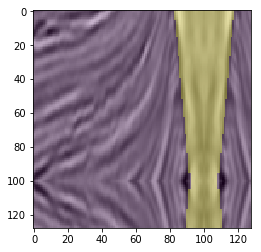

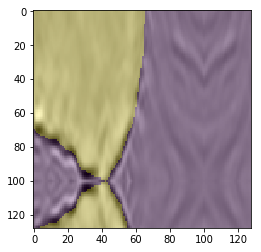

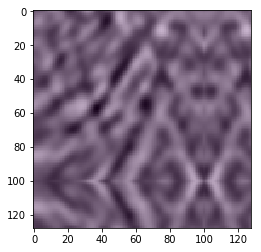

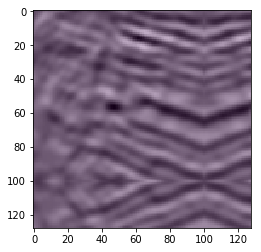

In [10]:
for i, data in enumerate(dl):
    if(i == 1):
        plt.show()
        break
    im = data['image']
    m = data['mask']
    show_masked_image(im[0], m[0])
    show_masked_image(im[1], m[1])
    show_masked_image(im[2], m[2])
    show_masked_image(im[3], m[3])

# Define Model

In [11]:
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# from torchvision import models
# import torch.nn.functional as F
# import math
# import torch.utils.model_zoo as model_zoo

In [15]:
class DecoderBlock(nn.Module):
    # USES ADDITION INSTEAD OF CONCATENATION ON SKIP CONNECTIONS
    
    
    def __init__(self, in_channels, n_filters):
        super().__init__()

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nn.ReLU(inplace=True)

        # B, C/4, H, W -> B, C/4, H, W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3,
                                          stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nn.ReLU(inplace=True)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x

class LinkNet34(nn.Module):
    def __init__(self, num_classes, num_channels=3):
        super().__init__()
        assert num_channels == 3, "num channels not used now. to use changle first conv layer to support num channels other then 3"
        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    # noinspection PyCallingNonCallable
    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        # d4 = e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)

        return f5

In [16]:
ln = LinkNet34(1,3)

In [17]:
ln.children

<bound method Module.children of LinkNet34(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

# Specify Loss Function(s)

# Training Loop

# Evaluation and Submission

# Debugging and Testing